In [0]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta

import matplotlib.pyplot as plt
import json

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import DoubleType, IntegerType

from pyspark.ml.feature import VectorAssembler, StandardScalerModel
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.functions import vector_to_array

import math

##Utility functions

In [0]:
 def train_kmeans_model(df, k, features_col):
    # Trains a k-means model.
    # Inspired by https://spark.apache.org/docs/latest/ml-clustering.html
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setFeaturesCol(features_col) # Set custom feature vector col
    model = kmeans.fit(df)
    return model

def compute_distance(point, cluster_id):
    # Function to compute distance between a point and its cluster centroid - "centers" needs to be callable
    center = centers[cluster_id]
    return float(math.sqrt(sum((p - c)**2 for p, c in zip(point, center))))

## Loading pretrained models

#### KMeans
Loading model, scaler (used for all models) and distance thresholds

In [0]:
# Load from saved path
kmeans_model = KMeansModel.load("/dbfs/tmp/kmeans_model")
scaler_model = StandardScalerModel.load("/dbfs/tmp/scaler_model")

# Load kmeans distance threshold
distance_threshold_json = dbutils.fs.head("dbfs:/tmp/kmeans_distance_threshold.json")
distance_threshold = json.loads(distance_threshold_json)

#### DBscan
Loading core points / vectors and dbscan params

In [0]:
# Load DBSCAN

# Load core points' coordinates
local_path = "/tmp/dbscan_core_points.npy"
dbfs_path = "dbfs:/tmp/dbscan_core_points.npy"
dbutils.fs.cp(dbfs_path, f"file:{local_path}")
core_vectors = np.load(local_path)  

# Broadcast to executors
bc_core = spark.sparkContext.broadcast(core_vectors)

# Load DBSCAN params
json_str = dbutils.fs.head("dbfs:/tmp/dbscan_params.json")
params = json.loads(json_str)
eps = float(params["eps"])
min_samples = int(params["min_samples"])

#### Stat. threshold model (univariate)
Load quantile thresholds for all variables

In [0]:
# Load thresholds from simple model
spark.sql("REFRESH TABLE quantile_thresholds") # refresh in case updated
threshold_sdf = spark.table("quantile_thresholds")
display(threshold_sdf.limit(10))

feature,lower_threshold,upper_threshold
temperature_2m,7.4,31.0
wind_gusts_10m,2.5,56.2
precipitation,0.0,1.1
cloud_cover,0.0,100.0


## Streaming simulation - Data input
Loading data from the API for the current week using the saved feature list

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[7]: ['temperature_2m', 'precipitation', 'wind_gusts_10m', 'cloud_cover']

In [0]:
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 38.716885,
    "longitude": -9.140233,
    "hourly": feature_cols,
    "forecast_days": 7
}

response = requests.get(url, params=params)
data = response.json()
forecast_df = pd.DataFrame(data['hourly'])

In [0]:
forecast_df

,time,temperature_2m,precipitation,wind_gusts_10m,cloud_cover
0,2025-06-06T00:00,17.2,0.0,15.8,51
1,2025-06-06T01:00,17.0,0.0,16.9,71
2,2025-06-06T02:00,16.9,0.0,19.8,99
3,2025-06-06T03:00,16.9,0.0,23.0,95
4,2025-06-06T04:00,16.7,0.0,20.9,86
...,...,...,...,...,...
163,2025-06-12T19:00,17.6,0.0,34.2,100
164,2025-06-12T20:00,16.9,0.0,31.0,100
165,2025-06-12T21:00,16.4,0.0,28.1,100
166,2025-06-12T22:00,16.3,0.0,28.1,100


#### Fake anomaly day
Creating a simulated additional day with extreme heat.

In [0]:
# Convert time column to datetime
forecast_df["time"] = pd.to_datetime(forecast_df["time"])

# Extract the last 24 hours
last_24h = forecast_df.tail(24).copy()

# Temp increase
temp_start_increase = 5.0
temp_end_increase = 25.0
increments = np.linspace(temp_start_increase, temp_end_increase, 24)

# Shift time + apply temperature increase
new_rows = []
for i, row in last_24h.iterrows():
    new_row = row.copy()
    new_row["time"] = row["time"] + timedelta(days=1)
    new_row["temperature_2m"] = row["temperature_2m"] + increments[i - last_24h.index[0]]
    new_rows.append(new_row)

# Append the new synthetic rows
forecast_df = pd.concat([forecast_df, pd.DataFrame(new_rows)], ignore_index=True)

In [0]:
forecast_df

,time,temperature_2m,precipitation,wind_gusts_10m,cloud_cover
0,2025-06-06 00:00:00,17.200000,0.0,15.8,51
1,2025-06-06 01:00:00,17.000000,0.0,16.9,71
2,2025-06-06 02:00:00,16.900000,0.0,19.8,99
3,2025-06-06 03:00:00,16.900000,0.0,23.0,95
4,2025-06-06 04:00:00,16.700000,0.0,20.9,86
...,...,...,...,...,...
187,2025-06-13 19:00:00,39.121739,0.0,34.2,100
188,2025-06-13 20:00:00,39.291304,0.0,31.0,100
189,2025-06-13 21:00:00,39.660870,0.0,28.1,100
190,2025-06-13 22:00:00,40.430435,0.0,28.1,100


### Spark DF -  Scaling
Scaling the freshly received data from the API for the models to work

In [0]:
forecast_sdf = spark.createDataFrame(forecast_df)

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_sdf = assembler.transform(forecast_sdf)

# Use loaded scaler model from training notebook
scaled_sdf = scaler_model.transform(assembled_sdf)

### Kmeans Clustering of forecast
Cluster forecast data / detect anomalies with KMeans

In [0]:
# Get cluster centers for outlier detection
centers = kmeans_model.clusterCenters()

# Distance user defined function - using compute distance utility function defined above
distance_udf = udf(compute_distance, DoubleType())

# Apply model
predicted_sdf = kmeans_model.transform(scaled_sdf)

# apply distance udf to all points
scored_sdf = predicted_sdf.withColumn(
    "distance_cluster_center",
    distance_udf(col("features_scaled"), col("prediction"))
)

# Detect anomalies based on distance threshold
scored_sdf = scored_sdf.withColumn(
    "is_anomaly",
    when(col("distance_cluster_center") > distance_threshold, 1).otherwise(0) # Distance threshold loaded above
)

### DBSCAN outlier identification of forecast
Cluster forecast data / detect anomalies with DBscan

In [0]:
def _is_dbscan_anomaly(scaled_list):
    """
    Function to detect and flag if is dbscan anomaly
    scaled_list: a Python list of 6 floats (the features_scaled).
    Return 1 if min distance > eps, else 0.
    """
    v = np.asarray(scaled_list, dtype=float)        # shape = (6,)
    core = bc_core.value                            # broadcast (n_core × 6)
    diffs = core - v                                # (n_core × 6)
    sq = np.sum(diffs * diffs, axis=1)              # (n_core,)
    min_dist = float(np.sqrt(np.min(sq)))           # scalar
    return 1 if (min_dist > eps) else 0

is_dbscan_anomaly = udf(_is_dbscan_anomaly, IntegerType())

In [0]:
# Vector into array
stream_with_arr = scaled_sdf.withColumn(
    "scaled_arr",
    vector_to_array(col("features_scaled"))
)

# Apply anomaly detection udf function
result_sdf = stream_with_arr.withColumn(
    "is_anomaly",
    is_dbscan_anomaly(col("scaled_arr"))
)

# select all feature cols for viz
final_stream = result_sdf.select(
    "time", 
    *feature_cols,
    "is_anomaly"
)

final_stream.show(20, truncate=False)

+-------------------+--------------+-------------+--------------+-----------+----------+
|time               |temperature_2m|precipitation|wind_gusts_10m|cloud_cover|is_anomaly|
+-------------------+--------------+-------------+--------------+-----------+----------+
|2025-06-06 00:00:00|17.2          |0.0          |15.8          |51         |0         |
|2025-06-06 01:00:00|17.0          |0.0          |16.9          |71         |0         |
|2025-06-06 02:00:00|16.9          |0.0          |19.8          |99         |0         |
|2025-06-06 03:00:00|16.9          |0.0          |23.0          |95         |0         |
|2025-06-06 04:00:00|16.7          |0.0          |20.9          |86         |0         |
|2025-06-06 05:00:00|16.4          |0.0          |20.2          |63         |0         |
|2025-06-06 06:00:00|16.5          |0.0          |16.6          |46         |0         |
|2025-06-06 07:00:00|17.3          |0.0          |20.2          |40         |0         |
|2025-06-06 08:00:00|

### Stat Threshold outlier identification of forecast
Cluster forecast data / detect anomalies with the basic Threshold Model

In [0]:
threshold_data = [
    (row["feature"], row["lower_threshold"], row["upper_threshold"])
    for row in threshold_sdf.collect()
]

sdf_stat_flagged = forecast_sdf # Copy forecast sdf to apply flags

for row in threshold_data:
    feature, low, high = row
    sdf_stat_flagged = sdf_stat_flagged.withColumn(
        f"{feature}_anomaly",
        when((col(feature) < lit(low)) | (col(feature) > lit(high)), 1).otherwise(0)
    )

### Visualization
Done through matplotlib / pandas as we're only looking at small data (~1 week)

#### KMeans
Visualization of the upcoming days (forecast) - anomalies flagged by KMeans

In [0]:
# Selection of relevant columns and conversion to pandas for visualization
plot_df = scored_sdf.select(
    "time",
    "temperature_2m",
    "wind_gusts_10m",
    "precipitation",
    "cloud_cover",
    "distance_cluster_center",
    "is_anomaly"
).orderBy("time").toPandas()

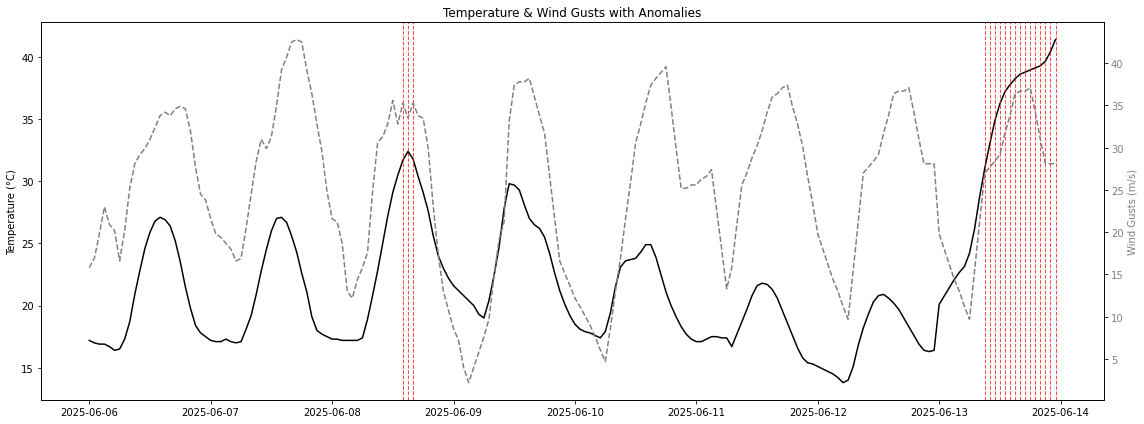

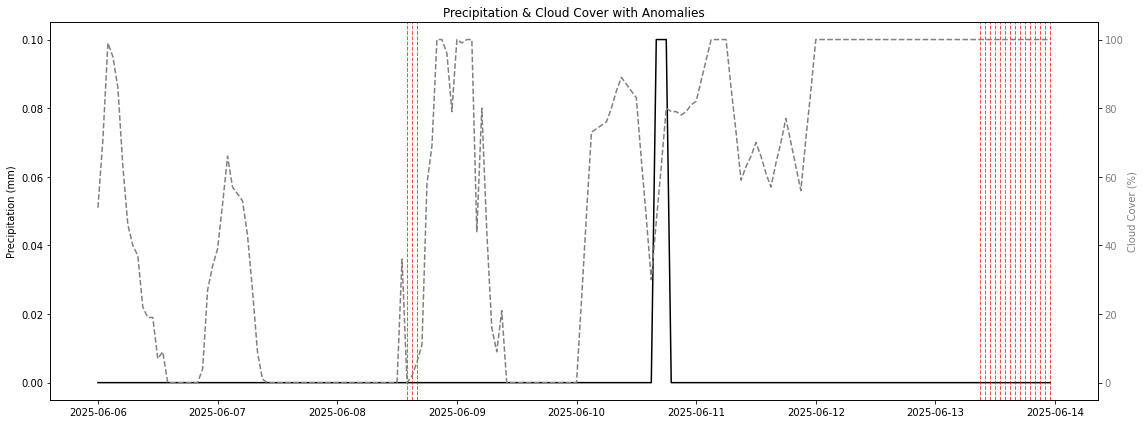

In [0]:
### Temperature & Wind Gusts
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df["wind_gusts_10m"], color="gray", linestyle='--', label="Wind Gusts (m/s)")
ax2.set_ylabel("Wind Gusts (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.get_xaxis().set_visible(False)  # Remove duplicate x labels

plt.title("Temperature & Wind Gusts with Anomalies")
fig.tight_layout()
plt.show()

### Precipitation & Cloud Cover
fig, ax3 = plt.subplots(figsize=(16, 6))

ax3.plot(plot_df["time"], plot_df["precipitation"], color="black", label="Precipitation (mm)")
ax3.set_ylabel("Precipitation (mm)", color="black")
ax3.tick_params(axis='y', labelcolor="black")

for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax3.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

ax4 = ax3.twinx()
ax4.plot(plot_df["time"], plot_df["cloud_cover"], color="gray", linestyle='--', label="Cloud Cover (%)")
ax4.set_ylabel("Cloud Cover (%)", color="gray")
ax4.tick_params(axis='y', labelcolor="gray")
ax4.get_xaxis().set_visible(False)

plt.title("Precipitation & Cloud Cover with Anomalies")
fig.tight_layout()
plt.show()


#### DBSCAN
Visualization of the upcoming days (forecast) - anomalies flagged by DBScan

In [0]:
# Save stream to pandas df
plot_stream_df = (
    final_stream
    .orderBy("time")
    .toPandas()
)

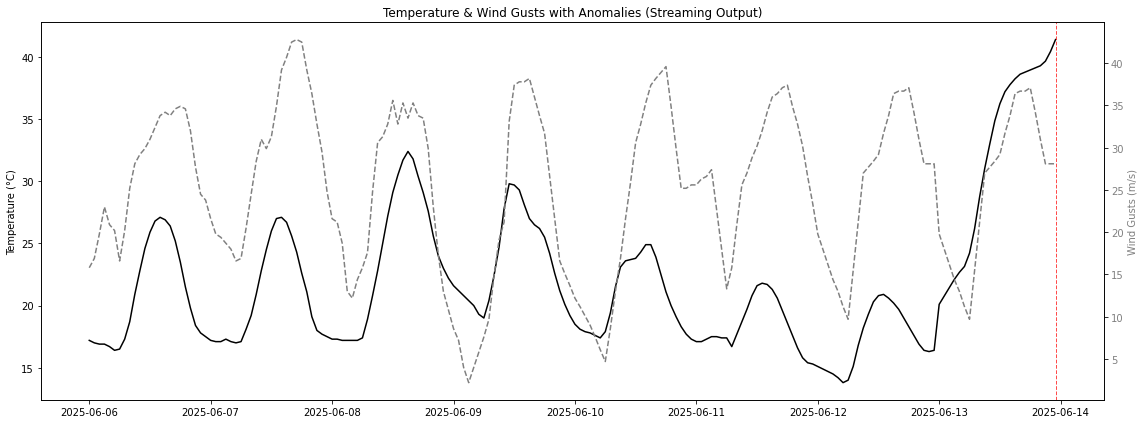

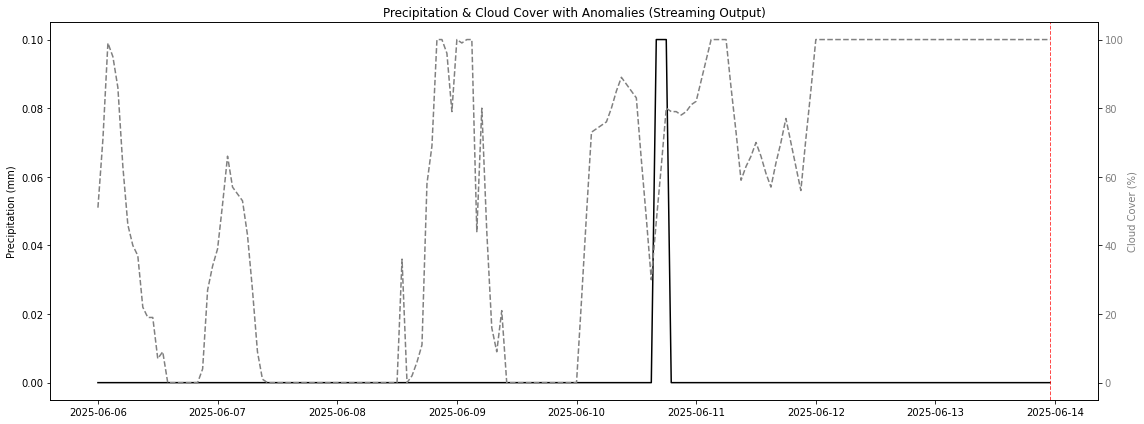

In [0]:
import matplotlib.pyplot as plt

### Temperature & Wind Gusts
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(plot_stream_df["time"], plot_stream_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Mark anomalies
for anomaly_time in plot_stream_df.loc[plot_stream_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Wind Gusts overlay
ax2 = ax1.twinx()
ax2.plot(plot_stream_df["time"], plot_stream_df["wind_gusts_10m"], color="gray", linestyle='--', label="Wind Gusts (m/s)")
ax2.set_ylabel("Wind Gusts (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.get_xaxis().set_visible(False)

plt.title("Temperature & Wind Gusts with Anomalies (Streaming Output)")
fig.tight_layout()
plt.show()


### Precipitation & Cloud Cover
fig, ax3 = plt.subplots(figsize=(16, 6))

ax3.plot(plot_stream_df["time"], plot_stream_df["precipitation"], color="black", label="Precipitation (mm)")
ax3.set_ylabel("Precipitation (mm)", color="black")
ax3.tick_params(axis='y', labelcolor="black")

for anomaly_time in plot_stream_df.loc[plot_stream_df["is_anomaly"] == 1, "time"]:
    ax3.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

ax4 = ax3.twinx()
ax4.plot(plot_stream_df["time"], plot_stream_df["cloud_cover"], color="gray", linestyle='--', label="Cloud Cover (%)")
ax4.set_ylabel("Cloud Cover (%)", color="gray")
ax4.tick_params(axis='y', labelcolor="gray")
ax4.get_xaxis().set_visible(False)

plt.title("Precipitation & Cloud Cover with Anomalies (Streaming Output)")
fig.tight_layout()
plt.show()


#### Stat. threshold model
Visualization of the upcoming days (forecast) - anomalies flagged by Stat. threshold model

In [0]:
# Select needed columns
plot_df = sdf_stat_flagged.select(
    "time",
    "temperature_2m",
    "wind_gusts_10m",
    "precipitation",
    "cloud_cover",
    "temperature_2m_anomaly",
    "wind_gusts_10m_anomaly",
    "precipitation_anomaly",
    "cloud_cover_anomaly"
).orderBy("time").toPandas()

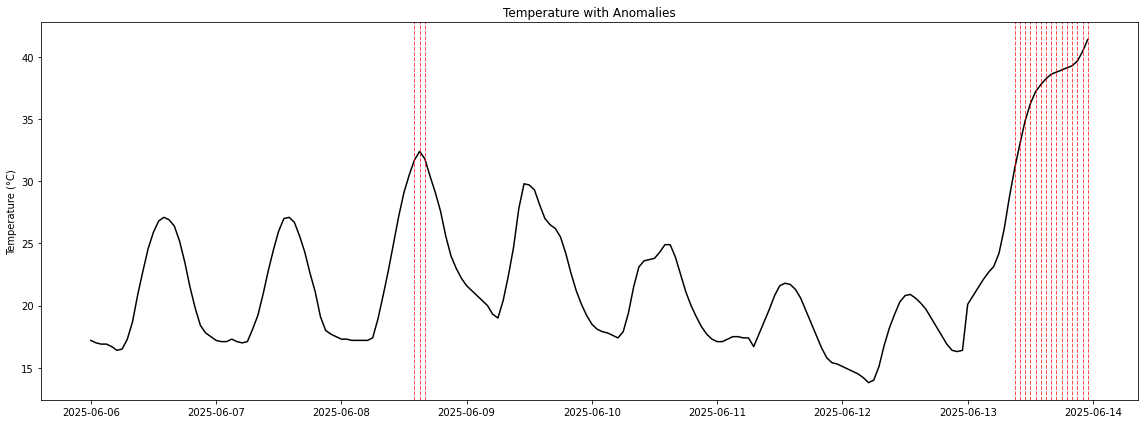

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["temperature_2m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Temperature with Anomalies")
fig.tight_layout()
plt.show()

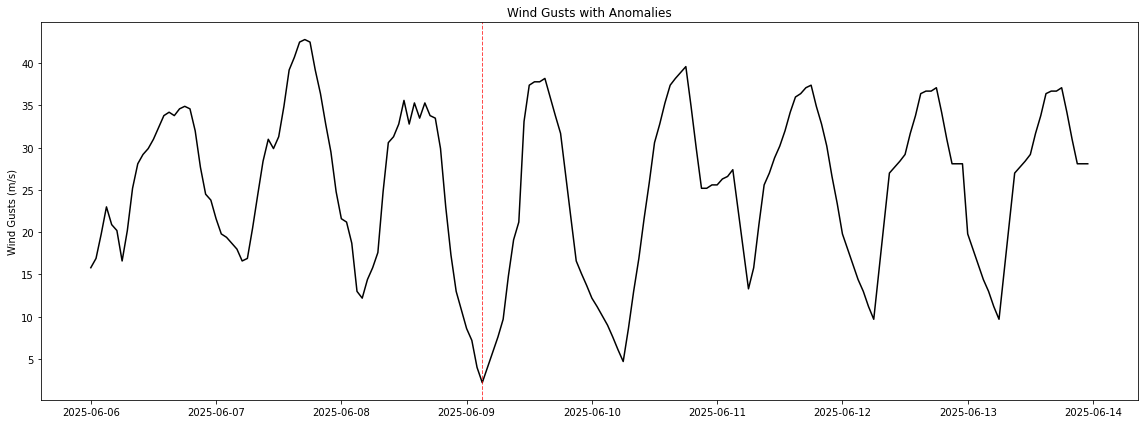

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["wind_gusts_10m"], color="black", label="Wind Gusts (m/s)")
ax1.set_ylabel("Wind Gusts (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["wind_gusts_10m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Wind Gusts with Anomalies")
fig.tight_layout()
plt.show()

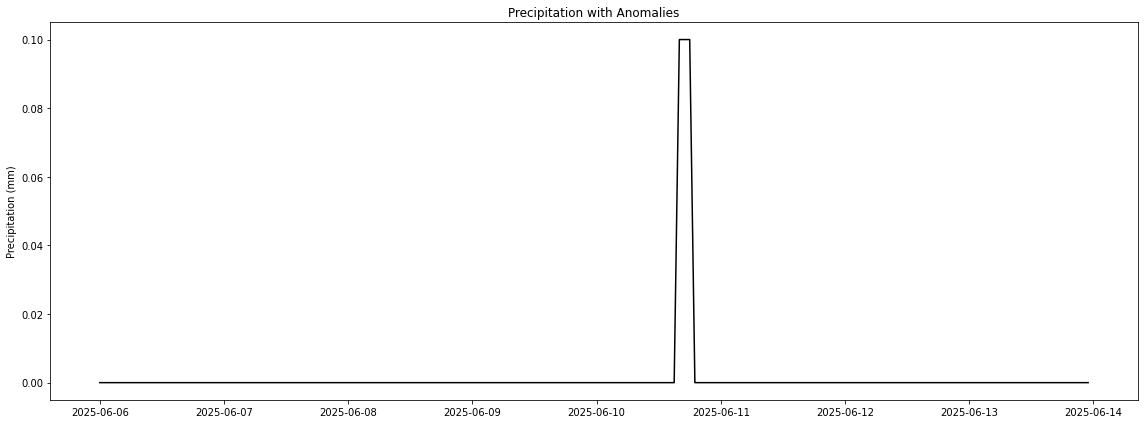

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["precipitation"], color="black", label="Precipitation (mm)")
ax1.set_ylabel("Precipitation (mm)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["precipitation_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Precipitation with Anomalies")
fig.tight_layout()
plt.show()

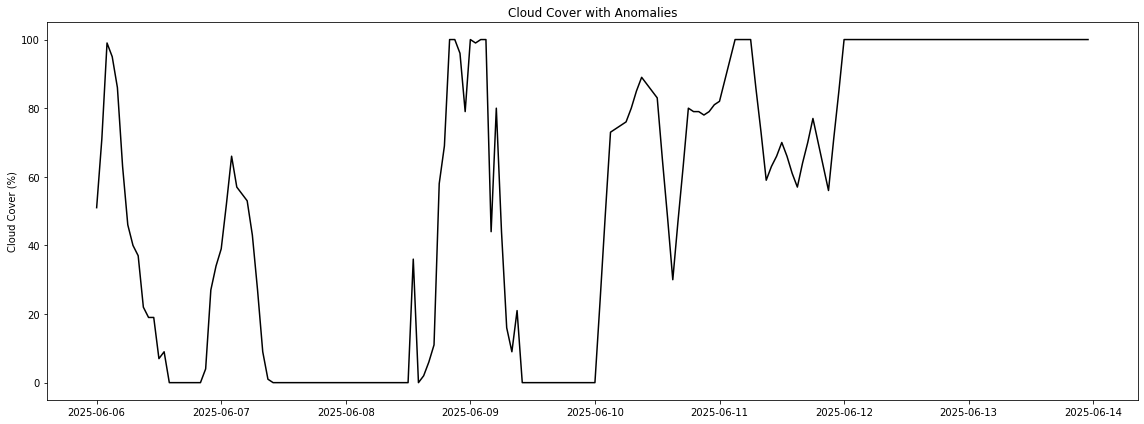

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["cloud_cover"], color="black", label="Cloud Cover (%)")
ax1.set_ylabel("Cloud Cover (%)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["cloud_cover_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Cloud Cover with Anomalies")
fig.tight_layout()
plt.show()